# 2D meshing: uz cross-section

By supplying the argument `type="uz"` and a `xsection_bounds` under the form `[[x1,y1], [x2,y2]]`, which parametrizes a line in `u`-coordinates, a out-of-plane cross-section of the `Component` can be meshed.

Repeating the first notebook's example:

2022-12-03 13:37:48.752 | INFO     | gdsfactory.config:<module>:48 - Load '/home/bilodeaus/Github/gdsfactory8_devsim/gdsfactory/gdsfactory' 6.3.5
/home/bilodeaus/Github/gdsfactory8_devsim/gdsfactory/gdsfactory/component.py:1472: UserWarning: Component 'Unnamed_088210f6' contains 1 Unnamed cells
  warnings.warn(


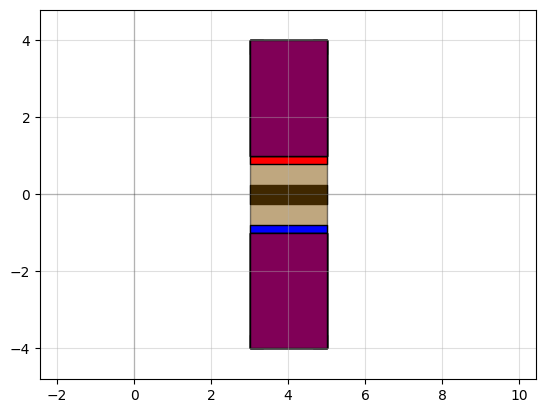

Unnamed_088210f6: uid 088210f6, ports [], references ['trim_1'], 0 polygons

In [2]:
import gdsfactory as gf
from gdsfactory.simulation.gmsh.mesh import create_physical_mesh
import meshio
import pyvista as pv

waveguide = gf.components.straight_pin(length=10, taper=None)
waveguide_trimmed = gf.Component()
waveguide_trimmed.add_ref(
    gf.geometry.trim(
        component=waveguide,
        domain=[[3, -4], [3, 4], [5, 4], [5, -4]],
    )
)

waveguide_trimmed

In [3]:
from gdsfactory.tech import LayerMap, LayerStack, LayerLevel, get_layer_stack_generic

filtered_layerstack = LayerStack(
    layers={
        k: get_layer_stack_generic().layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
        )
    }
)

In [4]:
filename = 'mesh'

def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    triangle_mesh = create_physical_mesh(mesh_from_file, "triangle", prune_z=True)
    meshio.write(f"{filename}.xdmf", triangle_mesh)
    mesh = pv.read(f"{filename}.xdmf")
    return mesh

Choosing the line going from `y=-4` to `y=4` at `x=4`, which crosses slab, via, and core:

In [5]:
mesh = waveguide_trimmed.to_gmsh(type="uz", xsection_bounds=[(4, -4), (4, 4)], layer_stack=filtered_layerstack, filename=f"{filename}.msh")
mesh = mesh_with_physicals(mesh, filename)


We can plot as usual (note that the `u-z` coordinates we are working in still map to `xy` for the plotter):

In [7]:
plotter = pv.Plotter()    # instantiate the plotter
plotter.add_mesh(mesh, style='wireframe', show_scalar=False)    # add a mesh to the scene
plotter.camera_position = "xy"
plotter.show()            # show the rendering window

ValueError: Invalid style "wireframemesh.msh".  Must be one of the following:
	"surface"
	"wireframe"
	"points"


## Mesh background

There is also a convenience argument to add a background mesh around the geometry (instead of defining a dummy polygon and layer in the layerstack with low mesh_order):